<a href="https://colab.research.google.com/github/tlambert03/misc/blob/main/colab/fdtd_lens_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

try:
  import fdtd
except ImportError:
  !pip install git+https://github.com/flaport/fdtd
  import fdtd

from tqdm import tqdm_notebook as tqdm
from IPython.display import HTML
from matplotlib import animation
from matplotlib.colors import PowerNorm

  Cloning https://github.com/flaport/fdtd to /tmp/pip-req-build-lylkaii1
  Running command git clone -q https://github.com/flaport/fdtd /tmp/pip-req-build-lylkaii1
  Created wheel for fdtd: filename=fdtd-0.0.1-cp36-none-any.whl size=27730 sha256=40bc4be6926b615bd4455d585e0434615d6724c0eec0edefd0812446a5d923d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-_7pwnz6y/wheels/b0/56/06/d57768cb16f516246533bc3cd35da3c0ebfd2fb2c25c6ad856
Successfully built fdtd


In [ ]:
# the whole thing in function form:

# specs I grabbed from a random edmund optic asphere
LENS = {
    'radius': 5, # radius of the lens
    'curve': 1.982161E-01, # main curvature
    'k': -1.055033 ,
    'As': [
        0,             # A2
        5.096600E-04,  # A4
        2.254951E-06,  # A6
        8.064402E-09,  # A8
        -9.079062E-10] # A10
}

def asphere(n, radius=5, curve=2, k=-1, As=[]):
    """returns a lens surface with `n` samples
    """
    s = np.linspace(-radius, radius, n)
    z = curve * s**2 / (1 + np.sqrt(1 - (1 + k) * curve**2 * s**2))
    for n, A in enumerate(As):
        z += A*s**(n*2 + 2)
    return z


def setup_grid(
    width = 30e-6,
    height = 20e-6,
    pixel = 50e-9,
    wavelength = 600e-9,
    lens=LENS,
    lens_scale=1,
    lens_position=6.5,
    extra_glass=1,
    refractive_index = 1.68,
    bes=None
):
    if bes:
        # enforce odd pixels for symmetry
        height += pixel
    grid = fdtd.Grid(shape = (height, width, 1),grid_spacing = pixel)
    # to avoid reflections at the edges, add "perfectly matched layers" (PML)
    grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
    grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")
    grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
    grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")

    if bes:
        grid[grid.Nx//2 - bes:grid.Nx//2 - bes+2, 13, 0] = fdtd.LineSource(period=wavelength/299792458, name="p1")
        grid[grid.Nx//2 + bes:grid.Nx//2 + bes+2, 13, 0] = fdtd.LineSource(period=wavelength/299792458, name="p2")
    else:
        grid[:, 11, 0] = fdtd.LineSource(period=wavelength/299792458, name="source")

    surface = asphere(grid.Nx, **lens)
    _pix = (lens['radius']*2) / (grid.Nx-1) # mm
    surface /= _pix
    ny = int(surface.max() + (extra_glass/_pix))
    _lens, yy = np.mgrid[:len(surface), :ny]
    _lens = np.zeros_like(yy)
    _lens[yy>surface[:, np.newaxis]] = 1
    _perm = np.ones((*_lens.shape,1))
    _perm += np.array(_lens[:,:,None])*(refractive_index**2 - 1)
    lens_start = int(_lens.shape[0]/lens_position)
    lensobj = fdtd.Object(permittivity=_perm, name="lens")
    grid[:, lens_start:lens_start + _lens.shape[1], 0] = lensobj
    return grid

def capture_frames(grid, total_time=1000, dt=10):
    frames = []
    grid.reset()
    for t in tqdm(np.arange(0, total_time, dt)):
        grid.run(total_time=dt, progress_bar=False)
        frames.append(np.sum(grid.E, -1)[:, :, 0])
    return frames

def plot_images(frames, fps=10, minmax=0.005):

    def animate(i):
        im.set_data(frames[i])
        return (im,)

    fig = plt.figure(frameon=False, figsize=(8,8))
    im = plt.imshow(frames[0], cmap='gray', vmin=-minmax, vmax=minmax)
    plt.axis('off')
    anim = animation.FuncAnimation(fig, animate,
                                   frames=tqdm(range(len(frames))),
                                   interval=1000/fps, blit=True)
    return anim


def plot_images_with_intensity(frames, binsize=16, minmax=0.005):
    """
      binsize is the number of frames overwhich to average the intensity image
    """
    if isinstance(frames, list):
      frames = np.stack(frames)
    squared = frames**2

    def init():
        im1.set_data(frames[0])
        im2.set_data(intensity(0))
        return (im1, im2)

    def animate(i):
        im1.set_data(frames[i])
        im2.set_data(intensity(i))
        return (im1, im2)

    def intensity(i):
        if i < binsize:
            i = squared[:i+1].mean(0)
        else:
            i = squared[i-binsize:i+1].mean(0)
        return i

    ratio = np.divide(*frames.shape[1:])

    fig = plt.figure(frameon=False, figsize=(1, 1/ratio), dpi=2*frames.shape[1])
    ax2 = fig.add_axes([0, 0, 1, .5,], label='ax1')
    ax1 = fig.add_axes([0, .5, 1, .5,], label='ax2')
    ax1.axis('off')
    ax2.axis('off')
    im1 = ax1.imshow(frames[0], cmap='bwr', vmin=-minmax, vmax=minmax)
    im2 = ax2.imshow(intensity(0), cmap='cubehelix', norm=PowerNorm(gamma=0.85),
                     vmin=0, vmax=squared[-40:].mean(0).max()*0.95)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=tqdm(range(len(frames))), interval=100,
                                   blit=True)

    return anim


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


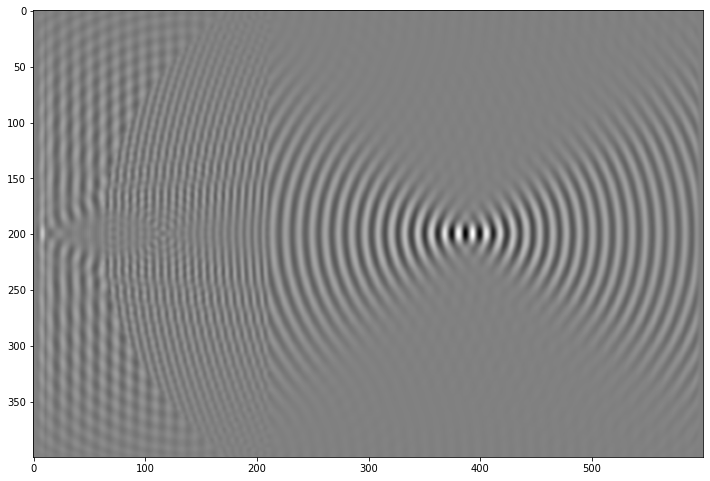

In [ ]:
mygrid = setup_grid()
frms = capture_frames(mygrid, 1200, 5)
plt.figure(figsize=(12,12))
plt.imshow(frms[-1], cmap='gray')

In [ ]:
anim=plot_images_with_intensity(frms, minmax=0.006, binsize=16)
HTML(anim.to_html5_video())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:127: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


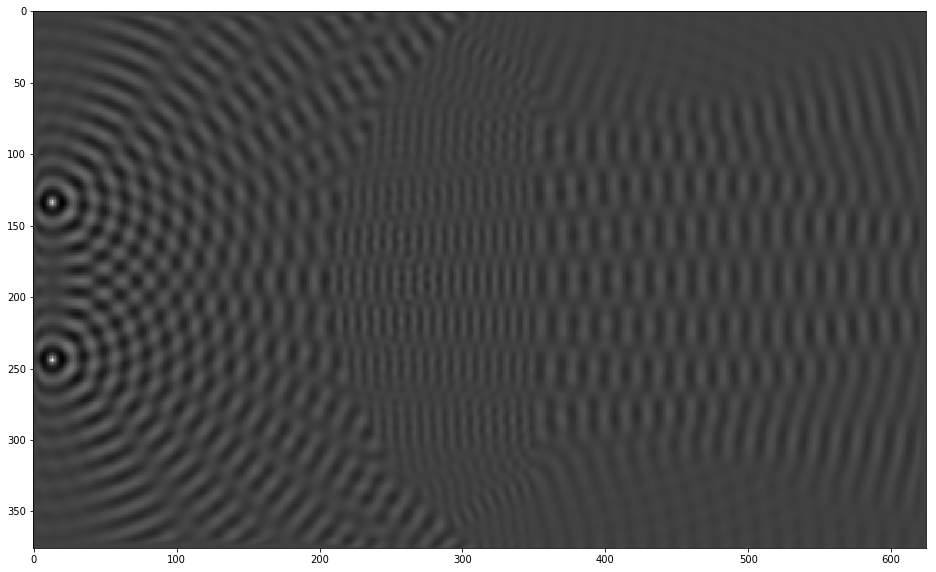

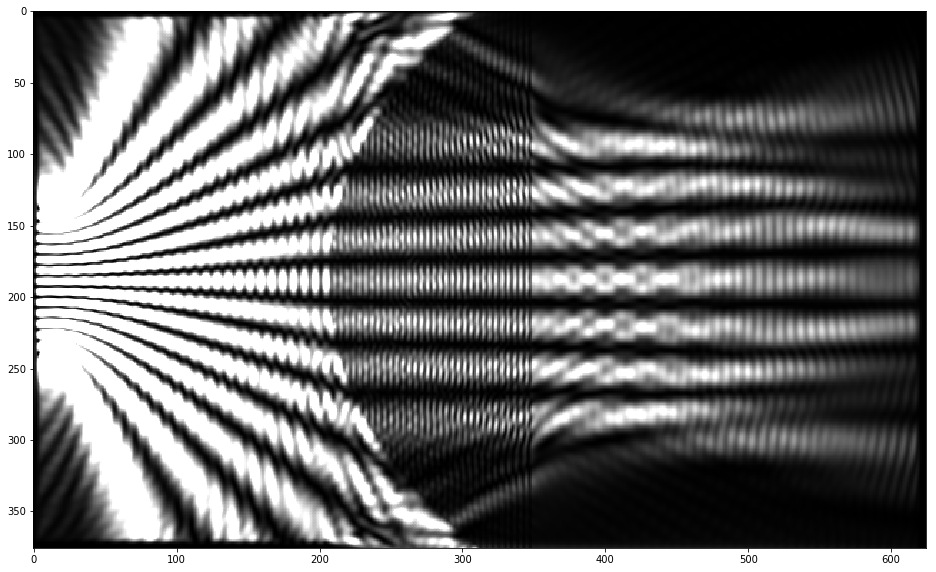

In [ ]:
#something approaching a bessel??
# one challenge here is positioning the points in the BFP
# of the lens... whose focal length is unclear?
# i guess there's a challenge for you!
# you could send a plane wave in the back side :)
mygrid = setup_grid(width=25e-6, height=15e-6, pixel=40e-9,
                    bes=55, lens_position=1.8)
frms2 = capture_frames(mygrid, 1200, 10)
plt.figure(figsize=(16,16))
plt.imshow(frms2[-1], cmap='gray')
plt.figure(figsize=(16,16))
plt.imshow((np.stack(frms2[-40:])**2).mean(0), cmap='gray', vmax=0.0003)